In [ ]:
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id = '1AQ6VrAnE1xGQRM_OPPgA9dsxXlPSC-SW'
file = drive.CreateFile({'id':id}) 
file.GetContentFile('bumble_hinge_review.csv')

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load in Dataset

In [ ]:
df=pd.read_csv('bumble_hinge_review.csv', index_col=False)
df.head()

,Name,Review,Rating,#ThumbsUp,Date&Time,App,language
0,Khy McCabe,"can not seem to log into account , i have try ...",1,0,18-02-2022 00:53,Bumble,en
1,rob cif,limited view without pay money . 90 % scam acc...,1,1,18-02-2022 00:53,Bumble,en
2,abhishek bhatia,this be the most trusted but bad app . this ap...,1,0,18-02-2022 00:25,Bumble,en
3,Myles Grothaus,just a money grab . i use to love this app bef...,1,0,17-02-2022 23:55,Bumble,en
4,David Barak,the app be `` crapp . '' if i switch away from...,1,0,17-02-2022 23:55,Bumble,en


In [ ]:
bumble_less_df=df[(df['#ThumbsUp']<=1)&(df.App=='Bumble')]
bumble_less_reviews = bumble_less_df['Review'].tolist()

In [ ]:
bumble_less_df.shape

(63635, 7)

In [ ]:
bumble_more_df=df[(df['#ThumbsUp']>1)&(df.App=='Bumble')]
bumble_more_reviews = bumble_more_df['Review'].tolist()

In [ ]:
bumble_more_df.shape

(15258, 7)

# Downsampling

In [ ]:
from random import sample
import random

random.seed(0)
sampled_bumble_less_reviews = sample(bumble_less_reviews,15258)

docs = sampled_bumble_less_reviews + bumble_more_reviews
labels = np.concatenate([np.zeros(15258), np.ones(15258)])

In [ ]:
len(docs)

30516

# Tokenize Text

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="UNKNOWN_TOKEN")
tokenizer.fit_on_texts(docs)

# Set a Maximum Sequence Length

In [ ]:
max(list(map(lambda docs: len(docs), tokenizer.texts_to_sequences(docs))))

730

# Integer Encode Documents

In [ ]:
MAX_SEQUENCE_LENGTH = 730

def integer_encode_documents(docs, tokenizer):
    return tokenizer.texts_to_sequences(docs)

from tensorflow.keras.preprocessing.sequence import pad_sequences

# integer encode the documents
encoded_docs = integer_encode_documents(docs, tokenizer)
print(f"Encoded docs: {encoded_docs[:5]}")
padded_docs = pad_sequences(encoded_docs, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print(f"Padded docs: {padded_docs[:5]}")

Encoded docs: [[75, 338, 20, 57, 131, 33, 12, 15, 8, 275, 70, 4, 10, 169, 49, 2, 76, 68, 22, 49, 134], [19, 68, 2, 124, 185, 19, 103, 2, 530, 150], [105, 11, 188, 192, 220, 60, 14, 187, 26, 62, 247, 12, 60, 4, 4500, 3738, 465, 20, 93, 4, 12, 79, 12, 682, 155, 124, 10, 246, 528, 4, 238, 78, 371, 4, 124, 27, 1112, 52, 3, 54, 77, 6, 138, 270, 13, 113, 1, 137, 290, 123, 2, 32, 295, 17, 5, 1187, 119, 11, 1188, 11], [12, 10, 4, 389, 252, 16, 11, 14, 9, 4, 2, 270, 9], [57, 24, 29, 3739, 92, 91, 651, 4501]]
Padded docs: [[ 75 338  20 ...   0   0   0]
 [ 19  68   2 ...   0   0   0]
 [105  11 188 ...   0   0   0]
 [ 12  10   4 ...   0   0   0]
 [ 57  24  29 ...   0   0   0]]


## Encode Labels
Convert positive/negative labels to their own columns.

In [ ]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
labels = to_categorical(encoder.fit_transform(labels))

In [ ]:
labels

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

# Perform Train/Test Split

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(padded_docs, labels, test_size=0.2)

# Import Keras Toolkit

In [ ]:
from random import randint
from numpy import array, argmax, asarray, zeros
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Embedding

In [ ]:
VOCAB_SIZE = int(len(tokenizer.word_index) * 1.1)

# Load in GloVe Vectors

In [ ]:
!wget https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
!unzip glove6b100dtxt.zip 

--2022-05-12 18:01:20--  https://dso-560-nlp-text-analytics.s3.amazonaws.com/glove6b100dtxt.zip
Resolving dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)... 54.231.204.105
Connecting to dso-560-nlp-text-analytics.s3.amazonaws.com (dso-560-nlp-text-analytics.s3.amazonaws.com)|54.231.204.105|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 137847651 (131M) [application/zip]
Saving to: ‘glove6b100dtxt.zip’

glove6b100dtxt.zip  100%[===================>] 131.46M  56.6MB/s    in 2.3s    

2022-05-12 18:01:22 (56.6 MB/s) - ‘glove6b100dtxt.zip’ saved [137847651/137847651]

Archive:  glove6b100dtxt.zip
  inflating: glove.6B.100d.txt       


In [ ]:
from typing import Dict
def load_glove_vectors()-> Dict:
    embeddings_index = {}
    with open('glove.6B.100d.txt') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    print('Loaded %s word vectors.' % len(embeddings_index))
    return embeddings_index


embeddings_index = load_glove_vectors()

Loaded 400000 word vectors.


# Load in Embeddings

In [ ]:
# create a weight matrix for words in training docs
embedding_matrix = zeros((VOCAB_SIZE, 100))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: # check that it is an actual word that we have embeddings for
        embedding_matrix[i] = embedding_vector

# Define in Model

In [ ]:
from keras.layers.recurrent import SimpleRNN, LSTM
from keras.layers import Flatten, Masking

def make_binary_classification_rnn_model(plot=False):
    model = Sequential()
    model.add(Embedding(VOCAB_SIZE, 100, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False))
    model.add(Masking(mask_value=0.0)) # masking layer, masks any words that don't have an embedding as 0s.
    model.add(SimpleRNN(units=64, input_shape=(1, MAX_SEQUENCE_LENGTH)))
    model.add(Dense(16))
    model.add(Dense(2, activation='softmax'))
    
    # Compile the model
    model.compile(
    optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    # summarize the model
    model.summary()
    
    if plot:
        plot_model(model, to_file='model.png', show_shapes=True)
    return model

# Compile Model

In [ ]:
model = make_binary_classification_rnn_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 730, 100)          1717200   
                                                                 
 masking (Masking)           (None, 730, 100)          0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 16)                1040      
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 1,728,834
Trainable params: 11,634
Non-trainable params: 1,717,200
_________________________________________________________________


# Fit the Model

In [ ]:
history = model.fit(X_train, y_train,validation_split = 0.1, epochs=5, verbose=1)

Epoch 1/5
687/687 [==============================] - 210s 301ms/step - loss: 0.6800 - accuracy: 0.5793 - val_loss: 0.6163 - val_accuracy: 0.6687
Epoch 2/5
687/687 [==============================] - 202s 295ms/step - loss: 0.6231 - accuracy: 0.6581 - val_loss: 0.5891 - val_accuracy: 0.7076
Epoch 3/5
687/687 [==============================] - 217s 316ms/step - loss: 0.6290 - accuracy: 0.6483 - val_loss: 0.6712 - val_accuracy: 0.5332
Epoch 4/5
687/687 [==============================] - 206s 299ms/step - loss: 0.6651 - accuracy: 0.5870 - val_loss: 0.6866 - val_accuracy: 0.5405
Epoch 5/5
687/687 [==============================] - 208s 303ms/step - loss: 0.6634 - accuracy: 0.5878 - val_loss: 0.6202 - val_accuracy: 0.6609


# Evaluate the Model

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=1)
print('Accuracy: %f' % (accuracy*100))

191/191 [==============================] - 15s 78ms/step - loss: 0.6239 - accuracy: 0.6596
Accuracy: 65.956748


In [ ]:
prob=model.predict(X_test)

In [ ]:
y_pred = [1 * (x[1]>=0.5) for x in prob]

In [ ]:
prob

array([[0.44504935, 0.5549506 ],
       [0.4860837 , 0.5139163 ],
       [0.4071549 , 0.59284514],
       ...,
       [0.39646783, 0.60353214],
       [0.4086762 , 0.5913238 ],
       [0.7628898 , 0.23711017]], dtype=float32)

In [ ]:
y_pred[:10]

[1, 1, 1, 1, 1, 0, 0, 1, 0, 1]

In [ ]:
y_test

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [ ]:
y_test_1=[x[1] for x in y_test]
y_test_1[:10]

[1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test_1, y_pred)

array([[1348, 1620],
       [ 458, 2678]])

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

def plot_roc_curve(fpr, tpr, roc_auc):
    plt.figure()
    lw = 2
    plt.figure(figsize=(6,6))
    plt.plot(fpr, tpr, color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [ ]:
prob_1=[x[1] for x in prob]
prob_1[:10]

[0.5549506,
 0.5139163,
 0.59284514,
 0.5686734,
 0.58878624,
 0.15091845,
 0.35178217,
 0.52807117,
 0.2970062,
 0.61775166]

<Figure size 432x288 with 0 Axes>

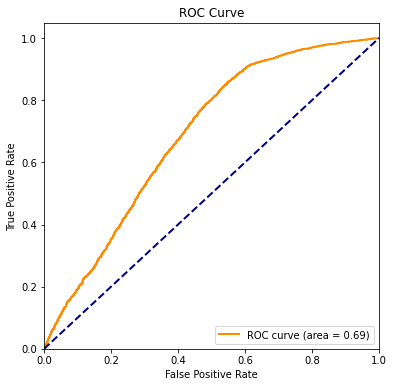

In [ ]:
fpr, tpr, thersholds = roc_curve(y_test_1, prob_1)
roc_auc = auc(fpr, tpr)
plot_roc_curve(fpr, tpr, roc_auc)